# Chapter 2: From Model to Production

In [1]:
!pip install Pillow --upgrade

In [2]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
import ipywidgets as widgets
from IPython.display import Image
import PIL

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [3]:
key = "XXXXXX"

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

We've successfully downloaded the URLs of 150 grizzly bears (or, at least, images that Bing Image Search finds for that search term)

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

## View/Download the Images from Bing Image Search

In [6]:
dest = './images/grizzly.jpg'
download_url(ims[0], dest)

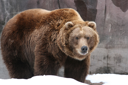

In [7]:
im = PIL.Image.open(dest)
im.to_thumb(128, 128)

In [8]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [9]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#390) [Path('bears/teddy/00000124.jpeg'),Path('bears/teddy/00000078.jpg'),Path('bears/teddy/00000128.JPG'),Path('bears/teddy/00000052.jpg'),Path('bears/teddy/00000012.jpg'),Path('bears/teddy/00000105.JPG'),Path('bears/teddy/00000137.jpg'),Path('bears/teddy/00000133.jpg'),Path('bears/teddy/00000041.jpg'),Path('bears/teddy/00000148.jpg')...]

## Check/Verify the downloaded files from Internet are corrupt

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
# to remove all of the failed images execute the code below

In [13]:
failed.map(Path.unlink)

(#0) []

## Some Jupyter Notebook hacks:

* When inside the parentheses of a function, pressing Shift and Tab simultaneously will display a window with the signature  of the function and a short description. Pressing these keys twice will expand the documentation, and pressing them three times will open a full window with the same information at the bottom of your screen
* In a cell, `?func_name` and executing will open a window with the signature of the function and a short description
* In a cell, `??func_name` and executing will open a window with the signature of the function, a short description, and the source code
* If you are using the fastai library, the contributors added a `doc` function for you: executing `doc(func_name)` in a cell will open a window with the signature of the function, a short description, and links to the source code on GitHub and the full documentation of the function in the library [docs](https://docs.fast.ai)
* Unrelated to the documentation but still very useful: to get help at any point if you get an error, type `%debug` in the next cell and execute to open the Python [debugger](https://oreil.ly/RShnP), which will let you inspect the content of every variable

In [14]:
?verify_images

## From Data to DataLoaders

Below a couple of things are happening. This is the main flow: raw data -> DataBlock -> DataLoader. Raw data is transformed into a DataBlock object by fastai and then it is used as a "template" for fastai's DataLoaders. 

* `blocks` => a tuple specifying the types we want for the independent (what you'll make the predictions from, in this case different types of bears) and dependent (the target or in this case the categories of types of bear for each image) variable
* `get_items=get_image_files` => For this `DataLoaders`, the underlying items will be file paths. You have to tell fastai to get the list of the files. `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, be default)
* `splitter=RandomSplitter(valid_pct=0.2, seed=42)` => takes the training and validation data and splits them so that the validation data is 20% of the data. The split is also random with random seed
* `get_y=parent_label` => you're telling fastai what function to call to create the labels in your dataset. `parent_label` is a function by fastai that simply gets tne name of the folder a file is in. Because we put each of our bear images into folders based on the type of bear, this is going give us the labels that we need
* Also `tfms` can be read as transforms. `item_tfms` takes each of the images and resizes them to be 128x128 pixels

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [16]:
# dls stands for dataloaders
dls = bears.dataloaders(path)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


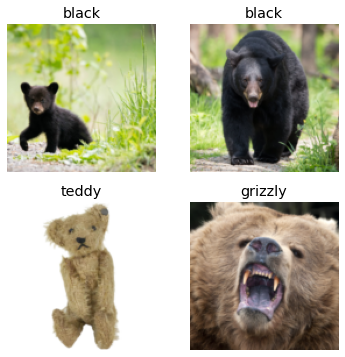

In [17]:
# by default, when you loop through a dataloader, fastai will give 64 items at a time stacked up into a single
# tensor
dls.valid.show_batch(max_n=4)

## Cropping Different parts of the Image at Random

In [18]:
# min_scale -> dretermins how much of hte image to select at minimum each time
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)

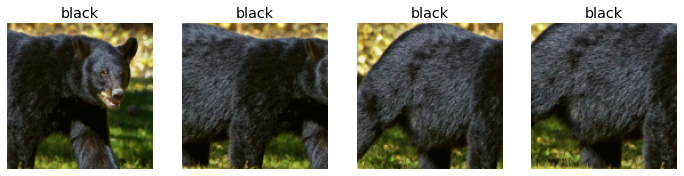

In [19]:
# unique=True -> is the same image repeated with different versions of the transform above
dls.train.show_batch(max_n=4, nrows=1, unique=True)

`RandomResizedCrop` is a specific example of a more general technique, called data augmentation. *Data augmentation* refers to creating random variations of our input data, such that they appear different but do not change the meaning of the data. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the `batch_tfms` parameter.

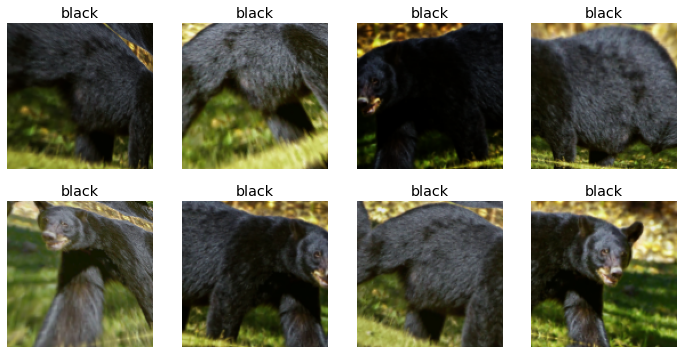

In [20]:
#aug_transforms techniques for images are rotation, flipping, perspective warping, brightness changes,
# & contrast changes
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using it to clean your Data

In [21]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.489800,0.098807,0.025641,00:13


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.263563,0.085295,0.025641,00:13
1,0.178117,0.082257,0.012821,00:14
2,0.125504,0.068309,0.012821,00:14
3,0.098015,0.062815,0.012821,00:14


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ub

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


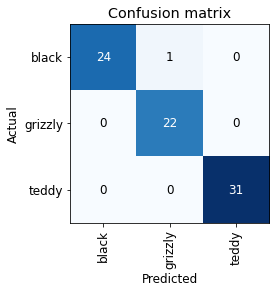

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

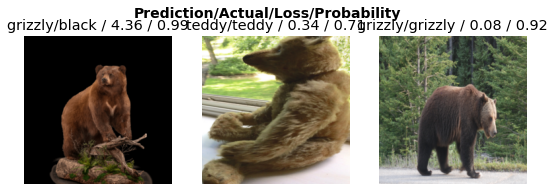

In [26]:
interp.plot_top_losses(3,nrows=1)

The intuitive approach to doing data cleaning is to do it *before* you train a model. But as you've seen in this case, a model can help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning. fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training vs. validation set and view the highest-loss imnages (in order), along with menus to allow images to be selected for removal or relabeling

In [31]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [32]:
# to delete all images selected for deletion
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [33]:
# to move images for which we've slected a different category
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### After cleaning, Retrain

In [34]:
bears = bears.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                 batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [35]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.674709,0.203096,0.103896,00:13


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.316666,0.051398,0.025974,00:13
1,0.201350,0.064574,0.012987,00:14
2,0.146127,0.091061,0.012987,00:15
3,0.121163,0.090967,0.012987,00:12


/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/ub

In [36]:
learn.export()

In [37]:
path = Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]

## Getting Predictions

In [38]:
learn_inf = load_learner(path/'export.pkl')

In [39]:
learn_inf.predict('./images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.6603e-05, 9.9997e-01, 3.7424e-06]))

The tensor above is the order of categories on in the *vocab* of the `DataLoaders`; that is, the stored list of all possible categories which you can get by executing the cell below

In [40]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## Creating a Notebook App from the Model

In [41]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [42]:
img = PILImage.create(btn_upload.data[-1])

In [43]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [44]:
pred, pred_idx, probs = learn_inf.predict(img)

In [45]:
lbl_pred = widgets.Label()
lbl_pred.value = f"Prediction: {pred}; Probability: {probs[pred_idx]:.04f}"
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9998')

In [46]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

Below is the code for the *click event handler*; that is a function that will be called when it's pressed.

In [47]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f"Prediction: {pred}; Probability: {probs[pred_idx]:.04f}"

In [48]:
btn_run.on_click(on_click_classify)

In [50]:
VBox([widgets.Label('Select your bear?'),
     btn_upload, btn_run, out_pl, lbl_pred])

In [51]:
VBox([widgets.Label('Select your bear?'),
     btn_upload, btn_run, out_pl, lbl_pred])